In [74]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [58]:
data = 'WHO-COVID-19-global-data.csv'

In [47]:
def get_country_df(country):
    df = pd.read_csv(data)
    df.columns = [i.strip() for i in df.columns]
    df.rename(columns={'Date_reported' : 'Date'}, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    country_groups = df.groupby('Country')
    country_df = country_groups.get_group(country)
    return country_df

In [175]:
def get_cases(country, how = 'New_cases'):
    country_df = get_country_df(country)
    
    filt = country_df[how] >= 1
    
    country_df = country_df[filt]
    
    return country_df.loc[:, ['Date', how]]

In [182]:
def get_deaths(country, how = 'New_deaths'):
    country_df = get_country_df(country)
    
    filt = country_df[how] >= 1
    
    country_df = country_df[filt]
    
    return country_df.loc[:, ['Date', how]]

In [184]:
def plot_line(country, plot = 'new cases'):
    # country comes in as a list
    
    country_dictionary = {}
         
    %matplotlib notebook    
    plt.style.use('seaborn-colorblind')
    plt.figure(figsize=(10,5))
    plt.xticks(rotation = 45)
    
    for i in country:
        if plot.lower() == "new cases":
            country_dictionary[i] = get_cases(i)
        
        elif plot.lower() == 'total cases':
            country_dictionary[i] = get_cases(i, 'Cumulative_cases')
            
        elif plot.lower() == 'new deaths':
            country_dictionary[i] = get_deaths(i)
            
        elif plot.lower() == 'total deaths':
            country_dictionary[i] = get_deaths(i, 'Cumulative_deaths')
            
        
    for country in country_dictionary:
        dates = country_dictionary[country]['Date']
        
        if plot.lower() == "new cases":
            y = country_dictionary[country]['New_cases']
        
        elif plot.lower() == 'total cases':
            y = country_dictionary[country]['Cumulative_cases']
            
        elif plot.lower() == 'new deaths':
            y = country_dictionary[country]['New_deaths']
            
        elif plot.lower() == 'total deaths':
            y = country_dictionary[country]['Cumulative_deaths']
        
        label = f'{plot}/Day {country}' if plot[:4].lower() == 'new' else f'{plot} {country}'
        plt.plot(dates, y, label = label, alpha = 0.75)
        
    plt.legend()


<IPython.core.display.Javascript object>


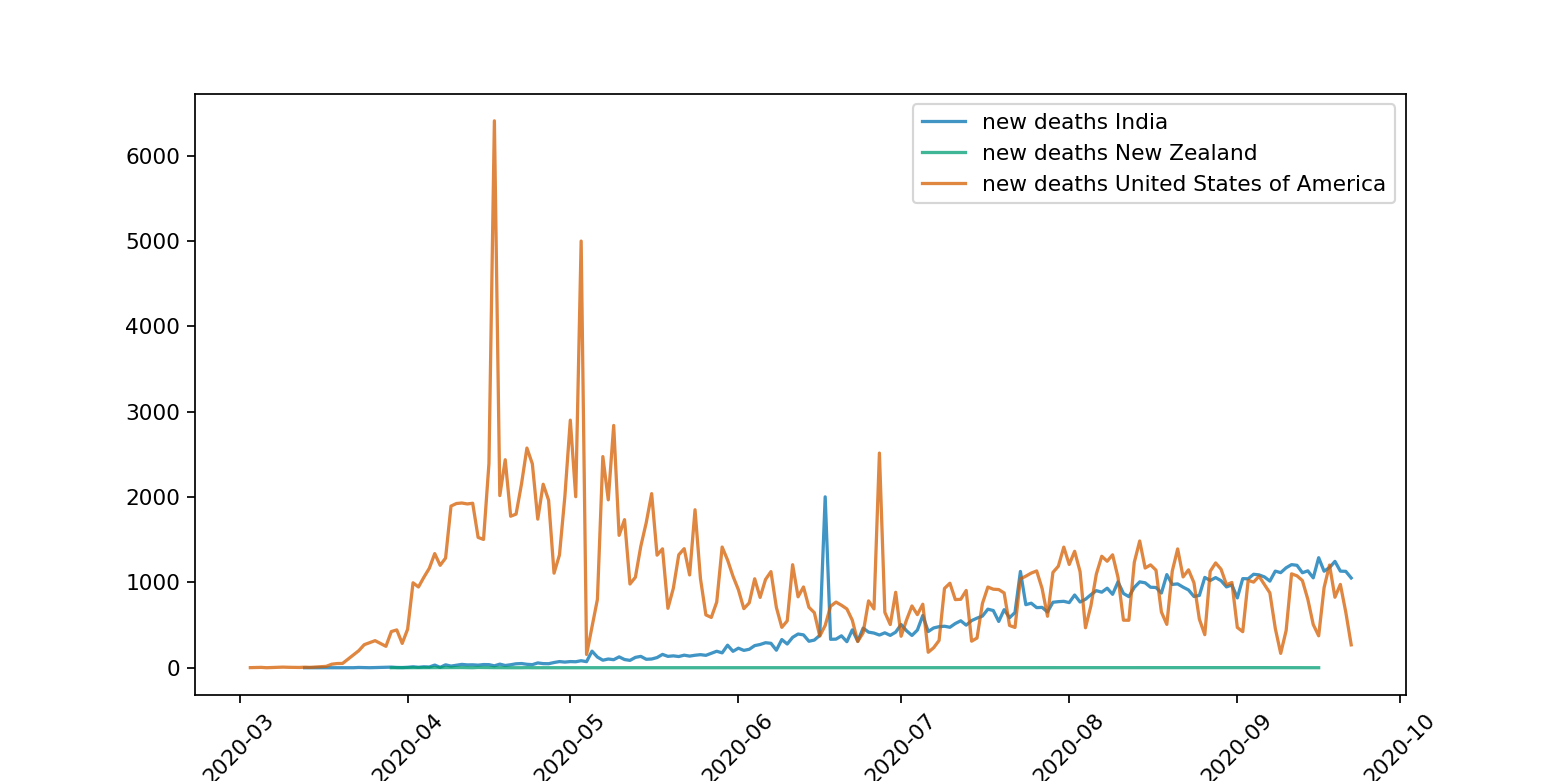

In [186]:
# plot(['India', 'United States of America'])
plot_line(['India', 'New Zealand', 'United States of America'], 'new deaths')

In [165]:
india = get_country_df('India')

filt = india['New_cases'] >= 1

ifilt = india[filt]

print(ifilt.loc[ifilt.index[0], 'Date'] - ifilt.loc[ifilt.index[-1], 'Date'])

ifilt.head(50)

-236 days +00:00:00


,Date,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
25371,2020-01-30,IN,India,SEARO,5,5,0,0
25374,2020-02-02,IN,India,SEARO,1,6,0,0
25375,2020-02-03,IN,India,SEARO,1,7,0,0
25403,2020-03-02,IN,India,SEARO,2,9,0,0
25405,2020-03-04,IN,India,SEARO,22,31,0,0
25406,2020-03-05,IN,India,SEARO,2,33,0,0
25407,2020-03-06,IN,India,SEARO,2,35,0,0
25408,2020-03-07,IN,India,SEARO,3,38,0,0
25409,2020-03-08,IN,India,SEARO,5,43,0,0
25410,2020-03-09,IN,India,SEARO,5,48,0,0
